## Hangman game implementation. from the dictionary of words.   

In [29]:
import random 
import pickle
import matplotlib.pyplot as plt

In [5]:
def getWordsSize():
    text_file = open("words_250000_train.txt","r"); 
    wordsList = text_file.read().splitlines()[200000:]; 
    text_file.close(); 
    s = [0]*30; 
    for word in wordsList:
        s[len(word)] += 1; 
    return [(i, n) for (i,n) in enumerate(s)]; 

# getWordsSize() 

In [6]:
class HangmanGame: #any object of this class can run the hangman game.
    def __init__(self, testingWords = None, curWordIndex = 0) -> None:
        print("initializing game engine"); 
        self.wordsList = testingWords; 
        if(self.wordsList is None):
            text_file = open("testWordsList.txt","r"); 
            self.wordsList = text_file.read().splitlines(); 
            text_file.close(); 
            random.shuffle(self.wordsList); #shuffle the words list so that we can get a random word each time.
        self.currentWordIndex = curWordIndex; # Index of the current word being used in the game
        print("initialization complete, total words available : ", len(self.wordsList)); 

    #so what we will output will just be the word, and keep count of guesses left ourself.

    def InputPlay(self, *args):
        guess = input("Guess a letter: "); 
        return guess; 


    def play(self, parentSolver = None, verbose = 2, tries_left = 6):
        if(verbose >= 1):
            print("Starting a new round of Hangman"); 
        
        if(self.currentWordIndex >= len(self.wordsList)):
            return None; #signifies that all the games have ended. 
        curWord = self.wordsList[self.currentWordIndex]; 
        self.currentWordIndex += 1; 
        curWord = [x for x in curWord]; 
        hiddenWord = ['_' for x in curWord]; 
        charsGuessed = set(); 
        IncorrectGuesses = set(); CorrectGuesses = set();  
        while(tries_left > 0 and hiddenWord != curWord): 
            if(verbose >= 1):
                print(" ".join(hiddenWord));  
            if(parentSolver is None):
                guess = self.InputPlay(hiddenWord,charsGuessed); #,IncorrectGuesses,CorrectGuesses); 
            else:
                guess = parentSolver.Solve(hiddenWord,charsGuessed, verbose = verbose); #,IncorrectGuesses,CorrectGuesses, verbose = verbose); 
            if(guess in charsGuessed):
                raise Exception("You already guessed the letter " + guess, "for : ", " ".join(hiddenWord)); 
            
            charsGuessed.add(guess); 
            if(guess in curWord and guess not in CorrectGuesses):
                CorrectGuesses.add(guess); 
                for i in range(len(curWord)):
                    if(curWord[i] == guess):
                        hiddenWord[i] = guess; 
            else:
                IncorrectGuesses.add(guess); 
                tries_left -= 1; 
                if(verbose == 2):
                    print("Incorrect guess. You have " + str(tries_left) + " tries left."); 
        if(tries_left == 0):
            if(verbose == 2):
                print("You lose. The word was " + " ".join(curWord)); 
            return (False, charsGuessed, IncorrectGuesses, ''.join(hiddenWord)); 
        else:
            if(verbose == 2):
                print("You win! The word is " + " ".join(curWord)); 
            return (True, charsGuessed, IncorrectGuesses, ''.join(hiddenWord)); 

        #then we can return some of the statistics of this game.
    

    


In [7]:
dictNgram = [0]*10; 
for i in range(2,10):
    with open('finaldict' + str(i) + 'gram.pickle', 'rb') as handle:
        dictNgram[i] = pickle.load(handle)


In [66]:
class NgramSolver:
    def __init__(self):
        self.guessedChars = set(); 
        return

    def Solve(self, hiddenWord, charsGuessed,verbose=0,version=4):
        return self.SolveN(hiddenWord, charsGuessed, verbose = verbose, n = version)
        
    def SolveNOld(self, word, charsGuessed, n = 5, verbose = 0, lowered = False): #3gram. 
        #now have to use 2-gram analysis to guess the next letter. 
        #we will use the 2-gram analysis from the training set.
        if(len(word) == 1 or n == 1): #if the size is only 1.
            for c in ['a','e','i','o','u','y']:
                if(c not in charsGuessed):
                    return c; 
        if(len(word) <= n and n != 2):
            return self.SolveN(word, charsGuessed, n = (n-1), lowered=True); 
        hiddenWord = ''.join(word); 
        if(not lowered):
            hcnt = hiddenWord.count('_');
            if(hcnt <= 2 and len(hiddenWord) >= 9 and (n < 7)):
                return self.SolveN(hiddenWord, charsGuessed, n = 7);
            if(hcnt <= 2 and len(hiddenWord) >= 7 and (n < 6)):
                return self.SolveN(hiddenWord, charsGuessed, n = 6); #we increase an n in this case.
            elif(hcnt/len(hiddenWord) <= 0.5 and (n < 5)):
                #print("going to 5 because current n is ", n); 
                return self.SolveN(hiddenWord, charsGuessed, n = 5); 
        hiddenWord = '^' + hiddenWord + '$';  #maybe we can remove this step?.
        if(hiddenWord[1:-1] == '_'*(len(hiddenWord)-2)):
        # if(hiddenWord == '_'*len(hiddenWord)):
            for c in ['a','e','i','o','u','y']:
                if(c not in charsGuessed):
                    return c; 
        
        #now we will move forward with 3 gram analysis of the result.
        freq = {};
        # freqVec = []
        # for i in range(len(hiddenWord)):
        #     freqVec.append({}); #an empty dictionary. 
        #considerCnt = [0]*len(hiddenWord); 
        for i in range(0,len(hiddenWord)-n+1):
            #starting our ngram analysis.
            curCheck = hiddenWord[i:i+n]; 
            #then we should consider the first 3 letters.
            # print(curCheck)
            if('_' not in curCheck):
                continue; #all are guessed.
            if(curCheck == '_'*n):
                continue; #all are blank here. 
            
            def checkFurther(curToCheck, pos, consts):
                if(pos >= len(curToCheck)):
                    #then we just update the frequencies. 
                    # print("checking", curToCheck);
                    if(curToCheck in dictNgram[n]):
                        # print("checked ", curToCheck); 
                        for (index,char) in enumerate(curToCheck):
                            if(char != '^' and char != '$'):                            
                                if(char in charsGuessed):
                                    continue #no need to update it's frequency.
                                if(char not in freq):
                                    freq[char] = 0; 
                                # if(char not in freqVec[i + index]):
                                #     freqVec[i + index][char] = 0;
                                # freqVec[i+index][char] += dictNgram[n][curToCheck];
                                freq[char] += (26**(consts-1))*dictNgram[n][curToCheck]; #multiplying this by consts to provide more weight.
                                #freq[char] += dict5gram[curToCheck]; #original case.
                    return; 
                if(curToCheck[pos] != '_'):
                    return checkFurther(curToCheck, pos + 1,consts + 1); #just check the next one as this one is already filled.
                else:
                    for c in range(ord('a'), ord('z') + 1):
                        if(chr(c) in charsGuessed):
                            continue; #this character has already been guessed.
                        checkFurther(curToCheck[:pos] + chr(c) + curToCheck[pos + 1:], pos + 1, consts); #removing the '_' from there.
                return; 
            checkFurther(curCheck, 0, 0); 

        #now we have the frequency possibilities of each character, and just need to predict the most likely one.
        
        if(len(freq) == 0):
            if(n == 2):
                raise Exception("No frequency found for n = 2, I wonder how ", hiddenWord, " is possible."); 

            return self.SolveN(hiddenWord, charsGuessed, n = n-1, lowered=True);
        charToGuess = max(freq, key = lambda x: freq[x]);   
        #self.guessedChars.add(charToGuess); #maybe not required.
        if(verbose >= 1):
            print("Guessing character ", charToGuess, " with frequency ", freq[charToGuess])
        
        return charToGuess; 

    def SolveN(self, word, charsGuessed, n = 5, verbose = 2, lowered = False): #3gram. 
        #now have to use 2-gram analysis to guess the next letter. 
        #we will use the 2-gram analysis from the training set.
        if(len(word) == 1 or n == 1): #if the size is only 1.
            for c in ['a','e','i','o','u','y']:
                if(c not in charsGuessed):
                    return c; 
        if(len(word) <= n and n != 2):
            return self.SolveN(word, charsGuessed, n = (n-1), lowered=True); 
        hiddenWord = ''.join(word); 
        if(not lowered):
            hcnt = hiddenWord.count('_');

            if(hcnt <= 2 and len(hiddenWord) >= 10 and (n < 7)):
                return self.SolveN(hiddenWord, charsGuessed, n = 7);
            if(hcnt <= 2 and len(hiddenWord) >= 7 and (n < 6)):
                return self.SolveN(hiddenWord, charsGuessed, n = 6); #we increase an n in this case.
            elif(hcnt/len(hiddenWord) <= 0.6 and (n < 5) and len(hiddenWord) >= 5):
                #print("going to 5 because current n is ", n); 
                return self.SolveN(hiddenWord, charsGuessed, n = 5); 
        hiddenWord = '^' + hiddenWord + '$';  #maybe we can remove this step?.
        if(hiddenWord[1:-1] == '_'*(len(hiddenWord)-2)):
        # if(hiddenWord == '_'*len(hiddenWord)):
            for c in ['a','e','i','o','u','y']:
                if(c not in charsGuessed):
                    return c; 
        
        #now we will move forward with 3 gram analysis of the result.
        freq = {};
        freqVec = []
        for i in range(len(hiddenWord)):
            freqVec.append({}); #an empty dictionary. 
        considerCnt = [0]*len(hiddenWord); 
        for i in range(0,len(hiddenWord)-n+1):
            #starting our ngram analysis.
            curCheck = hiddenWord[i:i+n]; 
            #then we should consider the first 3 letters.
            # print(curCheck)
            if('_' not in curCheck):
                continue; #all are guessed.
            if(curCheck == '_'*n):
                continue; #all are blank here. 
            for index in range(0, len(curCheck)):
                considerCnt[i+index] += 1; 
            def checkFurther(curToCheck, pos, consts):
                if(pos >= len(curToCheck)):
                    #then we just update the frequencies. 
                    # print("checking", curToCheck);
                    if(curToCheck in dictNgram[n]):
                        # print("checked ", curToCheck); 
                        for (index,char) in enumerate(curToCheck):
                            if(char != '^' and char != '$'):                            
                                if(char in charsGuessed):
                                    continue #no need to update it's frequency.
                                if(char not in freq):
                                    freq[char] = 0; 
                                if(char not in freqVec[i + index]):
                                    freqVec[i + index][char] = 0;
                                freqVec[i+index][char] += (27**(consts -1))*dictNgram[n][curToCheck]; 
                                #freq[char] += (26**(consts-1))*dictNgram[n][curToCheck]; #multiplying this by consts to provide more weight.
                    return; 
                if(curToCheck[pos] != '_'):
                    return checkFurther(curToCheck, pos + 1,consts + 1); #just check the next one as this one is already filled.
                else:
                    for c in range(ord('a'), ord('z') + 1):
                        if(chr(c) in charsGuessed):
                            continue; #this character has already been guessed.
                        checkFurther(curToCheck[:pos] + chr(c) + curToCheck[pos + 1:], pos + 1, consts); #removing the '_' from there.
                return; 
            checkFurther(curCheck, 0, 0); 
        #now we have the frequency possibilities of each character, and just need to predict the most likely one.
        for (i, dc) in enumerate(freqVec):
            if(len(dc) == 0):
                continue; 
            for (c, cnt) in dc.items():
                #print(c, cnt, considerCnt[i])
                if c not in freq:
                    freq[c] = 0; 
                freq[c] += (cnt/considerCnt[i]); 
        if(len(freq) == 0):
            # if(n == 2):
            #     raise Exception("No frequency found for n = 2, I wonder how ", hiddenWord, " is possible."); 

            return self.SolveN(hiddenWord, charsGuessed, n = n-1, lowered=True);
        #print("len of freq is ", len(freq))
        charToGuess = max(freq, key = lambda x: freq[x]);   
        #self.guessedChars.add(charToGuess); #maybe not required.
        if(verbose >= 1):
            print("Guessing character ", charToGuess, " with frequency ", freq[charToGuess])
        sum = 0; 
        x = []; y = []; 
        for (i,c) in enumerate(freq):
            sum += freq[c]; 
            x.append(c); y.append(freq[c]); 
            #print(c, freq[c]); 
        y = [t/sum for t in y]
        plt.plot(x,y); 
        spacedWord = [x + ' ' for x in hiddenWord[1:-1]]; 
        spacedWord = ''.join(spacedWord); 
        plt.title("predictions for word '" + spacedWord + "'");
        plt.show()
        return charToGuess; 



Guessing character  a  with frequency  130758.83333333333


'a'

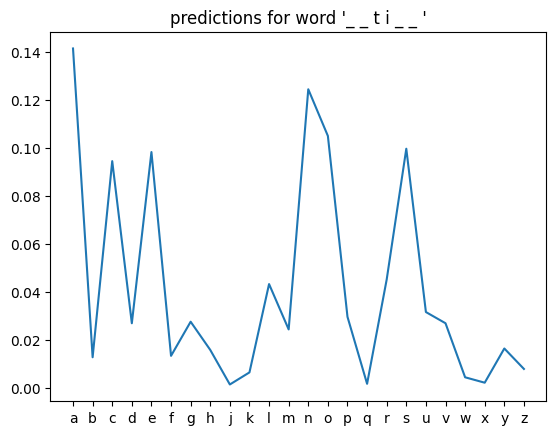

In [73]:
solver = NgramSolver(); 
solver.Solve(['_','_','t','i','_','_'], charsGuessed=['t','i'], verbose = 2, version=3)


Guessing character  a  with frequency  28008.333333333332


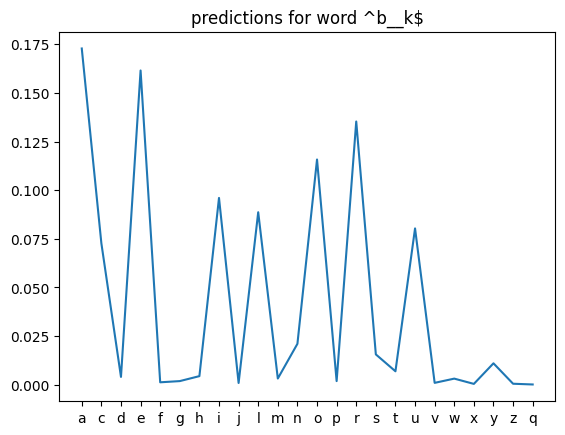

'a'

In [44]:
solver = NgramSolver();
solver.Solve(['b','_','_','k'], set(['b','k']), verbose = 2)

In [14]:
text_file = open("testWordsList.txt","r"); 
wordsList = text_file.read().splitlines(); 
text_file.close(); 
random.shuffle(wordsList);

In [19]:
failedStrings = []
successStrings = []
def Evaluate(curSolver, verbose = 0, limits = 40000):
    incorrectChars = 0; cnt = 0; 
    game = HangmanGame(curWordIndex=0); #initializes it with all the words of the game. 
    correctlyDone = 0; 
    squaredIncorrect = 0; totalCorrectGuesses = 0; 
    extremelyBad = 0; 
    curSolverObj = curSolver(); 
    while(game.currentWordIndex < limits):
    #while(game.currentWordIndex < 1000):
        if(verbose >= 1):
            print("playing game ", cnt, end = ", ? = "); 
        (didWin,totalGuesses,IncorrectGuesses, finalString) = game.play(parentSolver=curSolverObj, verbose = 0, tries_left=6); 
        curIncorrect = len(IncorrectGuesses); 
        # squaredIncorrect += curIncorrect**2; 
        incorrectChars += curIncorrect;  
        if(didWin):
            correctlyDone += 1; 
            successStrings.append(finalString)
            print("Won at ", finalString, end = " "); 
        else:
            failedStrings.append(finalString)
            print("Lost at ",finalString , end = ""); 
        if(curIncorrect >= 20):
            extremelyBad += 1; 
        cnt += 1; 
        print(" win rate: ",correctlyDone/cnt ," wins till now ", correctlyDone); 
        if(not didWin):
            print(" , actual= ", game.wordsList[game.currentWordIndex-1]);
    return (incorrectChars/cnt, correctlyDone/cnt, failedStrings, successStrings); 
    

In [20]:
stored = Evaluate(NgramSolver, verbose = 2)

initializing game engine
initialization complete, total words available :  45460
playing game  0, ? = Won at  homrai  win rate:  1.0  wins till now  1
playing game  1, ? = Won at  unvenereal  win rate:  1.0  wins till now  2
playing game  2, ? = Won at  kilndried  win rate:  1.0  wins till now  3
playing game  3, ? = Won at  noninfecting  win rate:  1.0  wins till now  4
playing game  4, ? = Lost at  _o_o_ win rate:  0.8  wins till now  4
 , actual=  gobos
playing game  5, ? = Won at  hardi  win rate:  0.8333333333333334  wins till now  5
playing game  6, ? = Lost at  retro_l__ win rate:  0.7142857142857143  wins till now  5
 , actual=  retroflux
playing game  7, ? = Won at  incommodities  win rate:  0.75  wins till now  6
playing game  8, ? = Lost at  _ambart win rate:  0.6666666666666666  wins till now  6
 , actual=  gambart
playing game  9, ? = Lost at  ta___ win rate:  0.6  wins till now  6
 , actual=  taffy
playing game  10, ? = Lost at  __t_ish win rate:  0.5454545454545454  wins

KeyboardInterrupt: 

Guessing character  n  with frequency  70298.83333333334


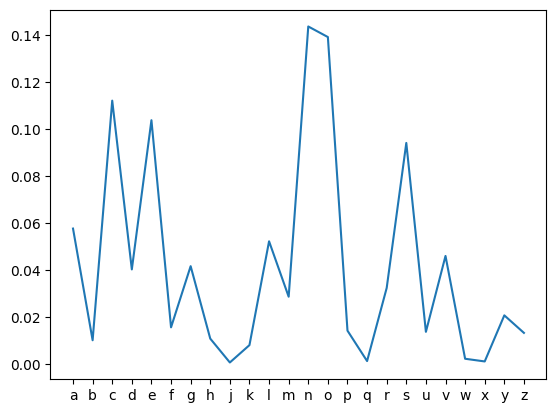

'n'

In [67]:
failedStrings

['_or_le',
 '_inst',
 'matat_a',
 '_istoriette',
 'suns_art',
 '_a_e',
 '_ail_arder',
 '_i_etoot_ed',
 '_rea_s',
 'peter_ort',
 'es_i',
 'tri_lyphal',
 '_i_a',
 'es_a_le',
 'slo__ing',
 'no__ea',
 'over_i_es',
 'ca_is',
 '_e_en___',
 're_i_iction',
 '_itchellsburg',
 'thousande_ed',
 '_ini_orous',
 't_ro_ean',
 'reele_ation',
 '_a__erproo_',
 '_os__onon_',
 '_u____',
 '_ar_er',
 '_rolit_ology',
 'se_',
 '_urio',
 'basen_i',
 'shortt_isted',
 'overi__i_ing',
 '_ele_',
 '_u_a_',
 'canni_ality',
 '__in__',
 'ta_ilelt',
 '_arnished',
 '_ar_',
 'una__licting',
 'coach_uilt',
 '_alary',
 '_i_roo_',
 '__o___',
 '_e__eathed',
 'e_a_',
 '_ar_ari_es',
 'e__e_erally',
 '_urtures',
 '_e_len',
 '_allmine',
 'su__u__ers',
 '_o_oc_cle',
 '_ull_ro__',
 '_estro_ed',
 'broo_land',
 '_ur_ier',
 'sla__ed',
 '_la__ulated',
 'cana_ol',
 '_oundage',
 'guaia_ums',
 '_henic',
 '____es',
 '__si_is',
 '_uttles',
 'en__erably',
 'in_uisitively',
 'ashie_',
 '_er_er_a_e',
 '_atesville',
 'creo_ol',
 'sta___a__',
 

In [ ]:
import gym
from gym import spaces

class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()
        self.action_space = spaces.Discrete(26); #26 letters in the alphabet that are our options
        
        pass
        
